# PARTE 1
## Introdução
O objetivo deste estudo de caso é construir um modelo de aprendizado de máquina que possa prever o tempo de entrega com base em diversos fatores, a fim de minimizar os atrasos e melhorar a satisfação geral do cliente.

## Plano de Ação
Este projeto será dividido em duas duas partes, dois arquivos `.ipynb`, neste irei fazer a limpeza e exploração dos dados. Na PARTE II, irei construir o modelo preditivo.



In [1]:
# Importando as bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import do dataset
df = pd.read_excel('data/data_delivery.xlsx')

In [3]:
display(df)

ID Delivery_person_ID  Delivery_person_Age  Delivery_person_Ratings  \
0      4607     INDORES13DEL02                   37                      4.9   
1      B379     BANGRES18DEL02                   34                      4.5   
2      5D6D     BANGRES19DEL01                   23                      4.4   
3      7A6A    COIMBRES13DEL02                   38                      4.7   
4      70A2     CHENRES12DEL01                   32                      4.6   
...     ...                ...                  ...                      ...   
45588  7C09      JAPRES04DEL01                   30                      4.8   
45589  D641      AGRRES16DEL01                   21                      4.6   
45590  4F8D     CHENRES08DEL03                   30                      4.9   
45591  5EEE    COIMBRES11DEL01                   20                      4.7   
45592  5FB2   RANCHIRES09DEL02                   23                      4.9   

       Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0                22.745049             75.892471                   22.765049   
1                12.913041             77.683237                   13.043041   
2                12.914264             77.678400                   12.924264   
3                11.003669             76.976494                   11.053669   
4                12.972793             80.249982                   13.012793   
...                    ...                   ...                         ...   
45588            26.902328             75.794257                   26.912328   
45589             0.000000              0.000000                    0.070000   
45590            13.022394             80.242439                   13.052394   
45591            11.001753             76.986241                   11.041753   
45592            23.351058             85.325731                   23.431058   

       Delivery_location_longitude Type_of_order Type_of_vehicle  \
0                        75.912471        Snack      motorcycle    
1                        77.813237        Snack         scooter    
2                        77.688400       Drinks      motorcycle    
3                        77.026494       Buffet      motorcycle    
4                        80.289982        Snack         scooter    
...                            ...           ...             ...   
45588                    75.804257         Meal      motorcycle    
45589                     0.070000       Buffet      motorcycle    
45590                    80.272439       Drinks         scooter    
45591                    77.026241        Snack      motorcycle    
45592                    85.405731        Snack         scooter    

       Time_taken(min)  
0                   24  
1                   33  
2                   26  
3                   21  
4                   30  
...                ...  
45588               32  
45589               36  
45590               16  
45591               26  
45592               36  

[45593 rows x 11 columns]

In [4]:
# Função que personaliza o método describe() do pandas 
# É necessário instalar o pacote jinja2 (pip install jinja2)
def descricão(df):
    resumo = pd.DataFrame({
        'Coluna': df.columns,
        'Tipo': df.dtypes.values,
        'Quantidade de Dados Não Vazios': df.notna().sum().values,
        'Quantidade de Dados Vazios': df.isna().sum().values,
        'Valores Únicos': df.nunique(),
        'Porcentagem de Valor Vazios (%)': (df.isna().mean() * 100).round(2).values
        
    })

    styled = (resumo.style
        .set_properties(**{
            'background-color': "#0f010194", 
            'border-color': 'black',
            'text-align': 'center'
        })
        .background_gradient(subset=['Porcentagem de Valor Vazios (%)'], cmap='Reds')
        .bar(subset=['Quantidade de Dados Vazios'], color='lightblue')
        .set_table_styles([
            {
                'selector': 'th',
                'props': [
                    ('background-color', '#0d253f'),
                    ('color', 'white'),
                    ('text-align', 'center'),
                    ('font-size', '12px')
                ]
            }
        ])
    )
    return styled


In [5]:
descricão(df)

Não temos dados ausentes e podemos ver a quantidade de valores únicos do nosso dataset. além do tipo de dados que estamos lidando.

In [6]:
df.describe().style.background_gradient(cmap='Blues')

# 1 Limpeza dos Dados

# 1.1 Localização de Origem e Destino 
Antes de iniciarmos nossa exploração dos dados, é importante sabermos a localidade dos restaurantes e locais de entrega presentes do nosso banco de dados. Para isso usarei a latitude e longitude fornecida.

In [7]:
# Grafico da localidade de origem e destino 
import plotly.express as px

df_origem = df[['Restaurant_latitude', 'Restaurant_longitude']].copy()
df_origem['Legenda'] = 'Origem - Restaurante'

df_destino = df[['Delivery_location_latitude', 'Delivery_location_longitude']].copy()
df_destino['Legenda'] = 'Destino - Local de Entrega'

df_plot = pd.concat([
    df_origem.rename(columns={
        'Restaurant_latitude': 'lat',
        'Restaurant_longitude': 'lon'
    }),
    df_destino.rename(columns={
        'Delivery_location_latitude': 'lat',
        'Delivery_location_longitude': 'lon'
    })
])

grafico = px.scatter_map(
    df_plot,
    lat='lat',
    lon='lon',
    color='Legenda',
    zoom=1.35
)

grafico.update_layout(
    map_style="open-street-map",
    margin={'r':0,'t':0,'b':0,'l':0}
)

grafico.show()

Nosso conjunto de dados é formado por localidades de restaurante que trabalham com o sistema de delivery na Índia. Entretanto, podemos ver que os dados possuem localizações que não correspondem ao país. Temos que tratar esse dados, eliminando as localidade incorretas. O conjunto de dados fornece a latitude e longitude, e com conhecimento de Geografia é possível usar essas informações em nosso favor.

![Latitude e Longitude](<img/Lat e Lon.png>)

Irei procurar nos dados, **latitutudes** e **longitudes** com valores negativos, que correspondem ao Hemisfério Sul, longe da Índia, e valores próximos de 0, por está próximo a **Linha do Equador**.

Vamos primeiro contar quantos dados estão errados, para isso irei contar quantas das localizações de latitude e longitude começam com `0` e `-`.

In [8]:
# Transforma dtype numerico para string
df['Delivery_location_latitude'] = df['Delivery_location_latitude'].astype(str)

# Verifica a primeira 'letra'
verificacao_delivery = df['Delivery_location_latitude'].str.startswith('0')
cont_deli = verificacao_delivery.sum()
print(f'Existem {cont_deli} localidade que começam com 0')

Existem 3640 localidade que começam com 0


In [9]:
# Transforma dtype numerico para string
df['Restaurant_latitude'] = df['Restaurant_latitude'].astype(str)

# Verifica a primeira 'letra'
verificacao_restaurant = df['Restaurant_latitude'].str.startswith('-')
cont_rest = verificacao_restaurant.sum()
print(f'Existem {cont_rest} localidades que começam com -')

Existem 431 localidades que começam com -


Agora que sabemos a quantidade de dados inconsistente, podemos excluir-los do nosso dataset.

In [10]:
# Exclui as linhas que começam com '0' e '-'
df = df[~df['Delivery_location_latitude'].astype(str).str.startswith('0')]
df = df[~df['Restaurant_latitude'].astype(str).str.startswith('-')]

In [11]:
# Transforma novamanete de string para numerico
df['Delivery_location_latitude'] = pd.to_numeric(df['Delivery_location_latitude'], errors='coerce')
df['Restaurant_latitude'] = pd.to_numeric(df['Restaurant_latitude'], errors='coerce')

In [12]:
df.describe().style.background_gradient(cmap='Blues')

In [13]:
# Grafico de Origem e Destino depois da limpeza
df_origem = df[['Restaurant_latitude', 'Restaurant_longitude']].copy()
df_origem['Legenda'] = 'Origem - Restaurante'

df_destino = df[['Delivery_location_latitude', 'Delivery_location_longitude']].copy()
df_destino['Legenda'] = 'Destino - Local de Entrega'

df_plot = pd.concat([
    df_origem.rename(columns={
        'Restaurant_latitude': 'lat',
        'Restaurant_longitude': 'lon'
    }),
    df_destino.rename(columns={
        'Delivery_location_latitude': 'lat',
        'Delivery_location_longitude': 'lon'
    })
])

grafico = px.scatter_map(
    df_plot,
    lat='lat',
    lon='lon',
    color='Legenda',
    zoom=3
)

grafico.update_layout(
    map_style="open-street-map",
    margin={'r':0,'t':0,'b':0,'l':0}
)

grafico.show()


Dados de localidades limpos, agora temos apenas os dados de restaurantes e ponto de entrega que ficam na Índia.

# 2 Análise Exploratória

# 2.1 Idade dos Delirevy
Vamos começar nossa análise, calculando a mediana da idade dos delivery (entregadores) por rating (avaliação).

In [14]:
# Agrupando Idade por Ratings do delivery
df_deli_age = df.groupby('Delivery_person_Ratings')['Delivery_person_Age'].median()

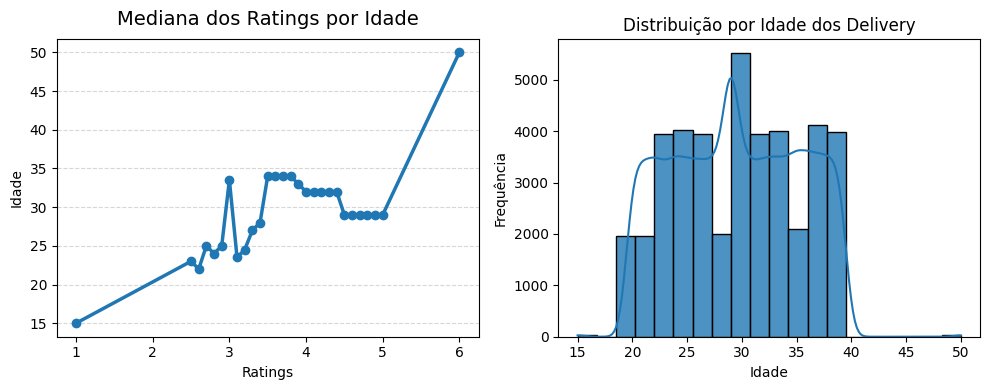

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4)) # Ajuste o figsize conforme necessário

# Gráfico 1 - Media da idade por avaliação
df_deli_age.plot( kind='line',
    ax=ax[0],
    color='#1f77b4',
    linewidth=2.5,
    marker='o')

ax[0].set_title('Mediana dos Ratings por Idade', fontsize=14, pad=10)
ax[0].set_xlabel('Ratings')
ax[0].set_ylabel('Idade')
ax[0].grid(axis='y', linestyle='--', alpha=0.5)

# Gráfico 2 - Distribuição por Idade dos Delivery
sns.histplot(df['Delivery_person_Age'], kde=True,
    bins=20,
    color='#1f77b4',
    edgecolor='black',
    alpha=0.8,
    ax=ax[1])

plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.title('Distribuição por Idade dos Delivery')

plt.tight_layout()
plt.show()


Vemos que existem entregradores(delirevy) com 15 e 50 anos. 

In [16]:
df.Delivery_person_Age.value_counts().sort_index().to_frame().style.background_gradient(cmap='Blues')

Os entregadores com 15 e 50 anos ao todo somam 49 pessoas. Irei excluir esses dados pois considero como sendo **outlines**, no nosso banco de dados.

In [17]:
# Exclui o entregadores com idade de 15 e 50 anos
df = df[~df['Delivery_person_Age'].isin([15, 50])]

In [18]:
df.describe().style.background_gradient(cmap='Blues')

# 2.2 Analisando o Tipo de Pedido
Outro elementos importante no nosso dataset é o Pedido. Qual os tipos? Quantos são?

Vamos calcular a quantidade de pedidos e a média de cada tipo de pedido feita pelos restaurante.

In [19]:
# Analisando o tipo de pedido
df_pedido = df.Type_of_order.value_counts(normalize=True)*100
print(df_pedido)

Type_of_order
Snack      25.312854
Meal       25.037977
Drinks     24.924650
Buffet     24.724520
Name: proportion, dtype: float64


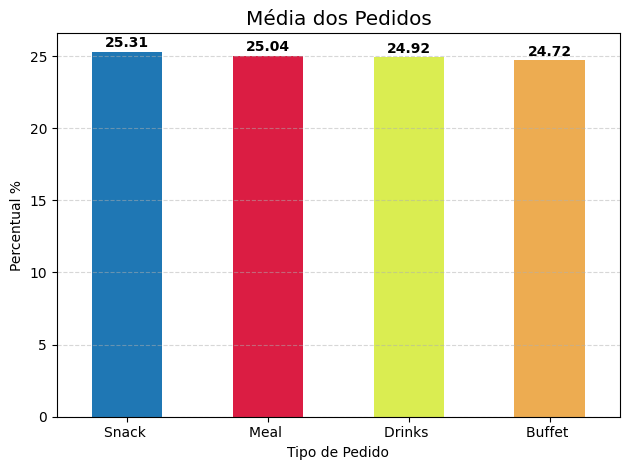

In [20]:
# Grafico tipo de pedido
df_pedido.plot(kind='bar',  color=['#1f77b4', '#DB1D43', '#DAED51', '#EDAC51'], rot=0)
plt.style.use('ggplot')
plt.title('Média dos Pedidos')
plt.xlabel('Tipo de Pedido')
plt.ylabel('Percentual %')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

for i, valor in enumerate(df_pedido.values):
    plt.text(i, valor + 0.3, f'{valor:.2f}', ha='center', fontsize=10, fontweight='bold')

plt.show()

É possível detectar que existe quatro tipo de pedido: 
- **Snack** - barra de cereal;
- **Meal** - pode ser entendido almoço ou janta, trazendo para o Brasil seria algo como Prato Feito (PF);
- **Drinks** - bebida, não especifica o tipo;
- **Buffet** - serviço de alimentação que leva opções variadas de comidas, como salgados, pratos quentes, finger foods ou até rodízios temáticos.

e também existe uma equivalência entre os tipos de pedidos realizados.  

# 2.3 Tipo de Veículo Usado
É de extrema importância para um serviço de delirevy a escolha do tipo de veículo é um fator crucial que impacta diretamente a eficiência, custo e rapidez da operação de delivery, devendo ser alinhada ao tipo de carga, distância e restrições urbanas. 

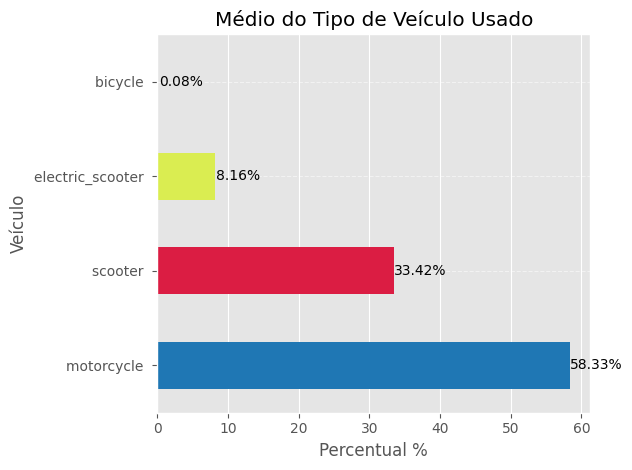

In [21]:
# Tipo de veiculo usado
df_veiculo = df.Type_of_vehicle.value_counts(normalize=True)*100

# Grafico
ax = df_veiculo.plot(kind='barh', color=['#1f77b4', '#DB1D43', '#DAED51', '#EDAC51'], rot=0)
plt.style.use('ggplot')
plt.title('Médio do Tipo de Veículo Usado')
plt.xlabel('Percentual %')
plt.ylabel('Veículo')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Loop para adicionar os rótulos de texto (porcentagens)
for p in ax.patches:
    # 'p' representa um retângulo (barra) no gráfico
    width = p.get_width()    # Pega a largura da barra
    height = p.get_height()  # Pega a altura da barra
    x, y = p.get_xy()        # Pega a posição inicial (x, y) da barra

    # Adiciona o texto na posição desejada (x, y)
    # x + width*0.02 move o texto ligeiramente para a direita da barra
    # y + height/2 centraliza o texto verticalmente na barra
    ax.text(x + width + 0.10, 
            y + height/2, 
            '{:.2f}%'.format(width), # Formata o texto como porcentagem (ex: 40%)
            ha='left',               # Alinhamento horizontal: esquerda
            va='center',             # Alinhamento vertical: centro
            color='black',           # Cor do texto
            fontsize=10)             # Tamanho da fonte

plt.tight_layout()
plt.show()

Temos quatro tipos de veículos:
- Bicicleta;
- Scooter Elétrica;
- Scooter;
- Moto.

São quatro veículos pequenos e ágeis, ideia para produtos pequenos, leves e urgente. Entregas urbanas de curta distância se beneficiam da agilidade de motos ou utilitários leves. Algo muito comum em serviços de delirevy são esses veículos mais rápidos e fáceis de manobrar em trânsito intenso, como motos, são usados para entregas expressas. 

# 2.4 Avaliação dos Entregradores (Delivery)

Uma forma melhor que analisarmos as notas dadas pelos clientes aos delivery (entregadores), é agrupar os valores em intervalos discretos para simplificar ou melhorar o desempenho do modelo que será construído.

In [22]:
# Contagem das notas
df.Delivery_person_Ratings.value_counts().sort_index().to_frame().style.background_gradient(cmap='Blues')

Para melhor avaliar as notas, irei usar a estratégia de agrupa-las e dividir elas em categorias: **Ruim**, **Regular**, **Bom**, **Ótimo**. Para isso usarei *bins*.
 
`bins` define os limites dos intervalos numéricos (as “caixas”) onde seus valores vão cair. Cada par consecutivo de números em bins forma um intervalo.

Por padrão:
- Intervalos são abertos à esquerda e fechados à direita: (a, b] significa a < x ≤ b

| Categoria | Intervalo  | Exemplos       |
| --------- | ---------- | -------------- |
| Ruim      | (0.5, 2.5] | 1, 1.5, 2, 2.4 |
| Regular   | (2.5, 3.5] | 2.6, 3, 3.4    |
| Bom       | (3.5, 4.5] | 3.6, 4, 4.4    |
| Ótimo     | (4.5, 6.5] | 4.6, 5, 6      |


In [23]:
# Separação por bin
bins = [0.5, 2.5, 3.5, 4.5, 6.5]
labels = ['Ruim', 'Regular', 'Bom', 'Ótimo']

df['rating_categoria'] = pd.cut(
    df['Delivery_person_Ratings'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

In [24]:
# Agrupando idade dos entregadores por avaliação
df_ratin_age = df.groupby('Delivery_person_Age')['rating_categoria'].value_counts()
display(df_ratin_age)

Delivery_person_Age  rating_categoria
20                   Ótimo               1589
                     Bom                  342
                     Regular               22
                     Ruim                   2
21                   Ótimo               1582
                                         ... 
38                   Ruim                   0
39                   Ótimo               1309
                     Bom                  637
                     Regular               22
                     Ruim                   0
Name: count, Length: 80, dtype: int64

In [25]:
# Contagem por categoria
cont_percen = df['rating_categoria'].value_counts(normalize=True)*100
print(cont_percen)

rating_categoria
Ótimo      74.764304
Bom        24.165119
Regular     1.027174
Ruim        0.043402
Name: proportion, dtype: float64


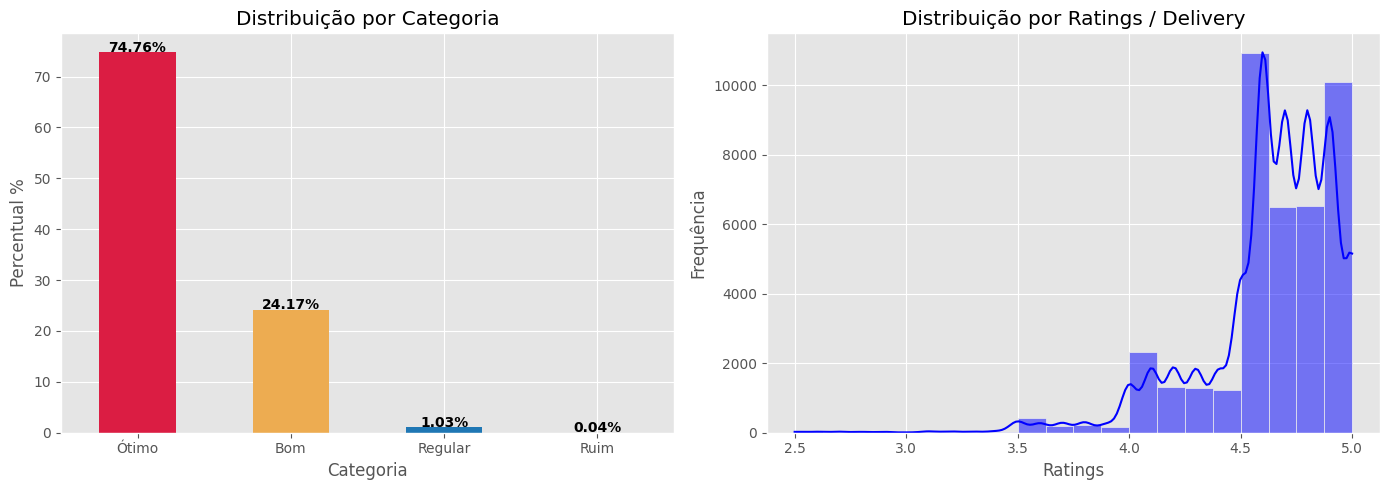

In [26]:
# Gráfico de Distribuição por Categoria e Ratings
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1 — Barras (Percentual)
cont_percen.plot(
    kind='bar',
    color=['#DB1D43', '#EDAC51', '#1f77b4', '#2ca02c'],
    ax=ax[0]
)

ax[0].set_title('Distribuição por Categoria')
ax[0].set_xlabel('Categoria')
ax[0].set_ylabel('Percentual %')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)

# Valores no topo das barras
for i, valor in enumerate(cont_percen):
    ax[0].text(
        i,
        valor + 0.1,
        f'{valor:.2f}%',
        ha='center',
        fontsize=10,
        fontweight='bold'
    )

# Gráfico 2 — Histograma
sns.histplot(
    df['Delivery_person_Ratings'],
    kde=True,
    bins=20,
    color='blue',
    ax=ax[1]
)

ax[1].set_title('Distribuição por Ratings / Delivery')
ax[1].set_xlabel('Ratings')
ax[1].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

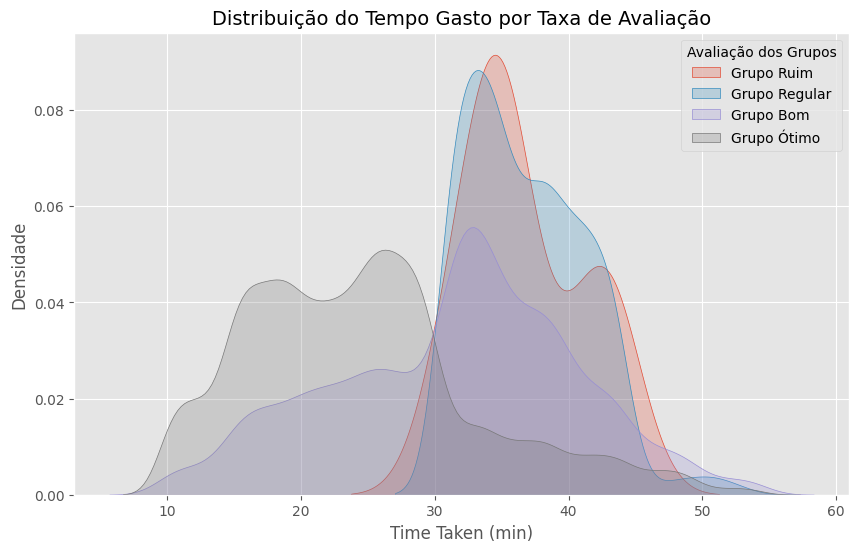

In [27]:
# Gráfico de Densidade da Avaliação por tempo de entrega
rating_groups = df.groupby('rating_categoria')['Time_taken(min)']

plt.figure(figsize=(10, 6))
for group, values in rating_groups:
    sns.kdeplot(values, label=f'Grupo {group}', fill=True)

plt.title('Distribuição do Tempo Gasto por Taxa de Avaliação', fontsize=14)
plt.xlabel('Time Taken (min)', fontsize=12)
plt.ylabel('Densidade', fontsize=12)
plt.legend(title='Avaliação dos Grupos')
plt.show()

# 2.5 Cálculo da Distância entre Restaurante e Local de Entrega
Vamos calcular a distância do restaurante até o local de entrega. Para cada linha do DataFrame, irei calcular a distância em quilômetros entre:
- Restaurante (latitude, longitude)
- Local de entrega (latitude, longitude)

E gravar o resultado na coluna `Distance`.

Essa função recebe:
- lat1, lon1 → ponto de origem
- lat2, lon2 → ponto de destino


In [28]:
def func_distancia(lat1, lon1, lat2, lon2):

    # Converte graus para radianos
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    # Diferença entre coordenadas
    newlon = lon2 - lon1
    newlat = lat2 - lat1

    # Fórmula de Haversine - calcula distância entre dois pontos em uma esfera.
    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    # Arco da Esfera
    dist = 2 * np.arcsin(np.sqrt(haver_formula ))

    # Converter para KM
    km = 6367 * dist #6367 for distance in KM for miles use 3958
    
    return km

Usei a **Fórmula de Haversine** que é usada para calcular a menor distância entre dois pontos na superfície de uma esfera, como a Terra, usando suas latitudes e longitudes.

In [29]:
# Colunas de origem e destino
dist_cols = ['Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude','Delivery_location_longitude']

Para cada linha:
- `x` é uma Series com 4 valores
- `x[0]` → latitude restaurante
- `x[1]` → longitude restaurante
- `x[2]` → latitude entrega
- `x[3]` → longitude entrega
- Calcula a distância
- Salva em `Distance`

In [30]:
df['Distance'] = df[dist_cols].apply(
    lambda x: func_distancia(x[0], x[1], x[2], x[3]), 
    axis=1)

In [31]:
display(df)

ID Delivery_person_ID  Delivery_person_Age  Delivery_person_Ratings  \
0      4607     INDORES13DEL02                   37                      4.9   
1      B379     BANGRES18DEL02                   34                      4.5   
2      5D6D     BANGRES19DEL01                   23                      4.4   
3      7A6A    COIMBRES13DEL02                   38                      4.7   
4      70A2     CHENRES12DEL01                   32                      4.6   
...     ...                ...                  ...                      ...   
45587  1178   RANCHIRES16DEL01                   35                      4.2   
45588  7C09      JAPRES04DEL01                   30                      4.8   
45590  4F8D     CHENRES08DEL03                   30                      4.9   
45591  5EEE    COIMBRES11DEL01                   20                      4.7   
45592  5FB2   RANCHIRES09DEL02                   23                      4.9   

       Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0                22.745049             75.892471                   22.765049   
1                12.913041             77.683237                   13.043041   
2                12.914264             77.678400                   12.924264   
3                11.003669             76.976494                   11.053669   
4                12.972793             80.249982                   13.012793   
...                    ...                   ...                         ...   
45587            23.371292             85.327872                   23.481292   
45588            26.902328             75.794257                   26.912328   
45590            13.022394             80.242439                   13.052394   
45591            11.001753             76.986241                   11.041753   
45592            23.351058             85.325731                   23.431058   

       Delivery_location_longitude Type_of_order Type_of_vehicle  \
0                        75.912471        Snack      motorcycle    
1                        77.813237        Snack         scooter    
2                        77.688400       Drinks      motorcycle    
3                        77.026494       Buffet      motorcycle    
4                        80.289982        Snack         scooter    
...                            ...           ...             ...   
45587                    85.437872       Drinks      motorcycle    
45588                    75.804257         Meal      motorcycle    
45590                    80.272439       Drinks         scooter    
45591                    77.026241        Snack      motorcycle    
45592                    85.405731        Snack         scooter    

       Time_taken(min) rating_categoria   Distance  
0                   24            Ótimo   3.023250  
1                   33              Bom  20.170858  
2                   26              Bom   1.551783  
3                   21            Ótimo   7.785510  
4                   30            Ótimo   6.206239  
...                ...              ...        ...  
45587               33              Bom  16.589850  
45588               32            Ótimo   1.488910  
45590               16            Ótimo   4.654271  
45591               26            Ótimo   6.228480  
45592               36            Ótimo  12.066815  

[41473 rows x 13 columns]

# 3 Preparando os Dados para Machine Learning

# 3.1 Aplicando OneHotEncoder
Aqui irei aplicar uma técnica chamada **OneHotEncoder**, sua função principal é converter variáveis categóricas nominais (dados que representam categorias sem uma ordem inerente) em um formato numérico que os algoritmos de aprendizado de máquina possam entender e processar de maneira eficaz. 

Aplicarei nas colunas `Type_of_vehicle` e `Type_of_order`.

In [32]:
# Contagem do Tipo de Veículo
df.Type_of_vehicle.value_counts() 

Type_of_vehicle
motorcycle           24192
scooter              13862
electric_scooter      3384
bicycle                 35
Name: count, dtype: int64

In [33]:
# Import
from sklearn.preprocessing import OneHotEncoder

# Criando o encoder (codificador)
tip_veiculo = OneHotEncoder(handle_unknown='ignore')

# Fazendo o fit com os dados
tip_veiculo = tip_veiculo.fit(df[['Type_of_vehicle']])

# Transformando os dados
tip_veiculo.transform(df[['Type_of_vehicle']])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 41473 stored elements and shape (41473, 4)>

In [34]:
# Visualizando em um array
tip_veiculo.transform(df[['Type_of_vehicle']]).toarray()

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], shape=(41473, 4))

In [35]:
# Transformando em um dataframe
df_tip_veiculo = pd.DataFrame(tip_veiculo.transform(df[['Type_of_vehicle']]).toarray())
df_tip_veiculo

0    1    2    3
0      0.0  0.0  1.0  0.0
1      0.0  0.0  0.0  1.0
2      0.0  0.0  1.0  0.0
3      0.0  0.0  1.0  0.0
4      0.0  0.0  0.0  1.0
...    ...  ...  ...  ...
41468  0.0  0.0  1.0  0.0
41469  0.0  0.0  1.0  0.0
41470  0.0  0.0  0.0  1.0
41471  0.0  0.0  1.0  0.0
41472  0.0  0.0  0.0  1.0

[41473 rows x 4 columns]

In [36]:
# Obtendo o nome das colunas
colunas_tip_veiculo = tip_veiculo.get_feature_names_out()
colunas_tip_veiculo

array(['Type_of_vehicle_bicycle ', 'Type_of_vehicle_electric_scooter ',
       'Type_of_vehicle_motorcycle ', 'Type_of_vehicle_scooter '],
      dtype=object)

In [37]:
# Formatando o nome das colunas no novo dataframe
df_tip_veiculo = pd.DataFrame(tip_veiculo.transform(df[['Type_of_vehicle']]).toarray(),
                              columns = colunas_tip_veiculo,
                              dtype = 'int32')
df_tip_veiculo

Type_of_vehicle_bicycle   Type_of_vehicle_electric_scooter   \
0                             0                                  0   
1                             0                                  0   
2                             0                                  0   
3                             0                                  0   
4                             0                                  0   
...                         ...                                ...   
41468                         0                                  0   
41469                         0                                  0   
41470                         0                                  0   
41471                         0                                  0   
41472                         0                                  0   

       Type_of_vehicle_motorcycle   Type_of_vehicle_scooter   
0                                1                         0  
1                                0                         1  
2                                1                         0  
3                                1                         0  
4                                0                         1  
...                            ...                       ...  
41468                            1                         0  
41469                            1                         0  
41470                            0                         1  
41471                            1                         0  
41472                            0                         1  

[41473 rows x 4 columns]

In [38]:
# Juntar (concatenar) os dois dataframe
df = pd.concat([df.reset_index(drop=True), df_tip_veiculo.reset_index(drop=True)], axis = 1)
display(df)

ID Delivery_person_ID  Delivery_person_Age  Delivery_person_Ratings  \
0      4607     INDORES13DEL02                   37                      4.9   
1      B379     BANGRES18DEL02                   34                      4.5   
2      5D6D     BANGRES19DEL01                   23                      4.4   
3      7A6A    COIMBRES13DEL02                   38                      4.7   
4      70A2     CHENRES12DEL01                   32                      4.6   
...     ...                ...                  ...                      ...   
41468  1178   RANCHIRES16DEL01                   35                      4.2   
41469  7C09      JAPRES04DEL01                   30                      4.8   
41470  4F8D     CHENRES08DEL03                   30                      4.9   
41471  5EEE    COIMBRES11DEL01                   20                      4.7   
41472  5FB2   RANCHIRES09DEL02                   23                      4.9   

       Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0                22.745049             75.892471                   22.765049   
1                12.913041             77.683237                   13.043041   
2                12.914264             77.678400                   12.924264   
3                11.003669             76.976494                   11.053669   
4                12.972793             80.249982                   13.012793   
...                    ...                   ...                         ...   
41468            23.371292             85.327872                   23.481292   
41469            26.902328             75.794257                   26.912328   
41470            13.022394             80.242439                   13.052394   
41471            11.001753             76.986241                   11.041753   
41472            23.351058             85.325731                   23.431058   

       Delivery_location_longitude Type_of_order Type_of_vehicle  \
0                        75.912471        Snack      motorcycle    
1                        77.813237        Snack         scooter    
2                        77.688400       Drinks      motorcycle    
3                        77.026494       Buffet      motorcycle    
4                        80.289982        Snack         scooter    
...                            ...           ...             ...   
41468                    85.437872       Drinks      motorcycle    
41469                    75.804257         Meal      motorcycle    
41470                    80.272439       Drinks         scooter    
41471                    77.026241        Snack      motorcycle    
41472                    85.405731        Snack         scooter    

       Time_taken(min) rating_categoria   Distance  Type_of_vehicle_bicycle   \
0                   24            Ótimo   3.023250                         0   
1                   33              Bom  20.170858                         0   
2                   26              Bom   1.551783                         0   
3                   21            Ótimo   7.785510                         0   
4                   30            Ótimo   6.206239                         0   
...                ...              ...        ...                       ...   
41468               33              Bom  16.589850                         0   
41469               32            Ótimo   1.488910                         0   
41470               16            Ótimo   4.654271                         0   
41471               26            Ótimo   6.228480                         0   
41472               36            Ótimo  12.066815                         0   

       Type_of_vehicle_electric_scooter   Type_of_vehicle_motorcycle   \
0                                      0                            1   
1                                      0                            0   
2                                      0                            1   
3                

In [39]:
df.groupby('Type_of_vehicle')[colunas_tip_veiculo].sum().style.background_gradient(cmap='Blues')

In [40]:
# Criando o encoder (codificador)
tip_pedido = OneHotEncoder(handle_unknown='ignore')

# Fazendo o fit com os dados
tip_pedido = tip_pedido.fit(df[['Type_of_order']])

# Transformando os dados
tip_pedido.transform(df[['Type_of_order']])

# Visualizando em um array
tip_pedido.transform(df[['Type_of_order']]).toarray()

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], shape=(41473, 4))

In [41]:
# Transformando em um dataframe
df_tip_pedido = pd.DataFrame(tip_pedido.transform(df[['Type_of_order']]).toarray())
df_tip_pedido

0    1    2    3
0      0.0  0.0  0.0  1.0
1      0.0  0.0  0.0  1.0
2      0.0  1.0  0.0  0.0
3      1.0  0.0  0.0  0.0
4      0.0  0.0  0.0  1.0
...    ...  ...  ...  ...
41468  0.0  1.0  0.0  0.0
41469  0.0  0.0  1.0  0.0
41470  0.0  1.0  0.0  0.0
41471  0.0  0.0  0.0  1.0
41472  0.0  0.0  0.0  1.0

[41473 rows x 4 columns]

In [42]:
# Obtendo o nome das colunas
colunas_tip_pedido = tip_pedido.get_feature_names_out()
colunas_tip_pedido

array(['Type_of_order_Buffet ', 'Type_of_order_Drinks ',
       'Type_of_order_Meal ', 'Type_of_order_Snack '], dtype=object)

In [43]:
# Formatando o nome das colunas no novo dataframe
df_tip_pedido = pd.DataFrame(tip_pedido.transform(df[['Type_of_order']]).toarray(),
                              columns = colunas_tip_pedido,
                              dtype = 'int32')
df_tip_pedido

Type_of_order_Buffet   Type_of_order_Drinks   Type_of_order_Meal   \
0                          0                      0                    0   
1                          0                      0                    0   
2                          0                      1                    0   
3                          1                      0                    0   
4                          0                      0                    0   
...                      ...                    ...                  ...   
41468                      0                      1                    0   
41469                      0                      0                    1   
41470                      0                      1                    0   
41471                      0                      0                    0   
41472                      0                      0                    0   

       Type_of_order_Snack   
0                         1  
1                         1  
2                         0  
3                         0  
4                         1  
...                     ...  
41468                     0  
41469                     0  
41470                     0  
41471                     1  
41472                     1  

[41473 rows x 4 columns]

In [44]:
# Juntar (concatenar) os dois dataframe
df = pd.concat([df.reset_index(drop=True), df_tip_pedido.reset_index(drop=True)], axis = 1)
display(df)

ID Delivery_person_ID  Delivery_person_Age  Delivery_person_Ratings  \
0      4607     INDORES13DEL02                   37                      4.9   
1      B379     BANGRES18DEL02                   34                      4.5   
2      5D6D     BANGRES19DEL01                   23                      4.4   
3      7A6A    COIMBRES13DEL02                   38                      4.7   
4      70A2     CHENRES12DEL01                   32                      4.6   
...     ...                ...                  ...                      ...   
41468  1178   RANCHIRES16DEL01                   35                      4.2   
41469  7C09      JAPRES04DEL01                   30                      4.8   
41470  4F8D     CHENRES08DEL03                   30                      4.9   
41471  5EEE    COIMBRES11DEL01                   20                      4.7   
41472  5FB2   RANCHIRES09DEL02                   23                      4.9   

       Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0                22.745049             75.892471                   22.765049   
1                12.913041             77.683237                   13.043041   
2                12.914264             77.678400                   12.924264   
3                11.003669             76.976494                   11.053669   
4                12.972793             80.249982                   13.012793   
...                    ...                   ...                         ...   
41468            23.371292             85.327872                   23.481292   
41469            26.902328             75.794257                   26.912328   
41470            13.022394             80.242439                   13.052394   
41471            11.001753             76.986241                   11.041753   
41472            23.351058             85.325731                   23.431058   

       Delivery_location_longitude Type_of_order Type_of_vehicle  ...  \
0                        75.912471        Snack      motorcycle   ...   
1                        77.813237        Snack         scooter   ...   
2                        77.688400       Drinks      motorcycle   ...   
3                        77.026494       Buffet      motorcycle   ...   
4                        80.289982        Snack         scooter   ...   
...                            ...           ...             ...  ...   
41468                    85.437872       Drinks      motorcycle   ...   
41469                    75.804257         Meal      motorcycle   ...   
41470                    80.272439       Drinks         scooter   ...   
41471                    77.026241        Snack      motorcycle   ...   
41472                    85.405731        Snack         scooter   ...   

       rating_categoria   Distance  Type_of_vehicle_bicycle   \
0                 Ótimo   3.023250                         0   
1                   Bom  20.170858                         0   
2                   Bom   1.551783                         0   
3                 Ótimo   7.785510                         0   
4                 Ótimo   6.206239                         0   
...                 ...        ...                       ...   
41468               Bom  16.589850                         0   
41469             Ótimo   1.488910                         0   
41470             Ótimo   4.654271                         0   
41471             Ótimo   6.228480                         0   
41472             Ótimo  12.066815                         0   

       Type_of_vehicle_electric_scooter   Type_of_vehicle_motorcycle   \
0                                      0                            1   
1                                      0                            0   
2                                      0                            1   
3                                      0                            1   
4                                      0                            0   
...

In [45]:
df.groupby('Type_of_order')[colunas_tip_pedido].sum().style.background_gradient(cmap='Blues')

# 3.2 Taxa de Avaliação
Aqui irei utilizar outra estrátegia de encoder o OrdinalEncoder que é utilizada para converter dados categóricos ordinais em valores numéricos inteiros. Ele é projetado para variáveis que possuem uma ordem ou hierarquia natural.

In [46]:
# Contagem dos valores da coluna rating_categoria
df.rating_categoria.value_counts()

rating_categoria
Ótimo      31007
Bom        10022
Regular      426
Ruim          18
Name: count, dtype: int64

In [47]:
# Separando uma variável com a taxax de avaliação
avaliacao = ['Ruim', 'Regular', 'Bom', 'Ótimo']

In [48]:
# import
from sklearn.preprocessing import OrdinalEncoder

In [49]:
# Definindo o codificador
enc = OrdinalEncoder(categories = [avaliacao], dtype = 'int32')

# Fazendo o fit
enc = enc.fit(df[['rating_categoria']])

# transformação
enc.transform(df[['rating_categoria']])

array([[3],
       [2],
       [2],
       ...,
       [3],
       [3],
       [3]], shape=(41473, 1), dtype=int32)

In [50]:
# salvando valores em uma nova coluna
df['Avaliacao'] = enc.transform(df[['rating_categoria']])

In [51]:
# Verificando a contagem dos valores depois do OrdinalEncoder
df[['rating_categoria', 'Avaliacao']].value_counts().sort_index().to_frame().style.background_gradient(cmap='Blues')

# 3.3 Relação do Tipo de Pedido por Veículo Utilizado
O objetivo é calcular a taxa de veiculo utilizado por tipo de pedido feito.

In [52]:
# Agrupando coluna Type_of_order e Type_of_vehicle
df.groupby('Type_of_order')['Type_of_vehicle'].value_counts().to_frame().style.background_gradient(cmap='Blues')

In [53]:
# Contagem do tipo de pedido por veiculo utilizado
counts = (
    df.groupby('Type_of_order')['Type_of_vehicle']
    .value_counts()
    .rename('count')
    .reset_index()
)

# Total por tipo de pedido
total = (
    df.groupby('Type_of_order')
    .size()
    .rename('total')
    .reset_index()
)

# Merge
freq = counts.merge(total, on='Type_of_order')

# Proporção do veículo dentro do tipo de pedido
freq['vehicle_ratio'] = freq['count'] / freq['total']

df = df.merge(
    freq[['Type_of_order', 'Type_of_vehicle', 'vehicle_ratio']], # selecionando somente as colunas necessárias do DataFrame freq.
    on=['Type_of_order', 'Type_of_vehicle'], #“Junte os dados quando essas duas colunas forem iguais”
    how='left' # Mantenha TODAS as linhas do DataFrame da esquerda (df)
)

In [54]:
display(df)

ID Delivery_person_ID  Delivery_person_Age  Delivery_person_Ratings  \
0      4607     INDORES13DEL02                   37                      4.9   
1      B379     BANGRES18DEL02                   34                      4.5   
2      5D6D     BANGRES19DEL01                   23                      4.4   
3      7A6A    COIMBRES13DEL02                   38                      4.7   
4      70A2     CHENRES12DEL01                   32                      4.6   
...     ...                ...                  ...                      ...   
41468  1178   RANCHIRES16DEL01                   35                      4.2   
41469  7C09      JAPRES04DEL01                   30                      4.8   
41470  4F8D     CHENRES08DEL03                   30                      4.9   
41471  5EEE    COIMBRES11DEL01                   20                      4.7   
41472  5FB2   RANCHIRES09DEL02                   23                      4.9   

       Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0                22.745049             75.892471                   22.765049   
1                12.913041             77.683237                   13.043041   
2                12.914264             77.678400                   12.924264   
3                11.003669             76.976494                   11.053669   
4                12.972793             80.249982                   13.012793   
...                    ...                   ...                         ...   
41468            23.371292             85.327872                   23.481292   
41469            26.902328             75.794257                   26.912328   
41470            13.022394             80.242439                   13.052394   
41471            11.001753             76.986241                   11.041753   
41472            23.351058             85.325731                   23.431058   

       Delivery_location_longitude Type_of_order Type_of_vehicle  ...  \
0                        75.912471        Snack      motorcycle   ...   
1                        77.813237        Snack         scooter   ...   
2                        77.688400       Drinks      motorcycle   ...   
3                        77.026494       Buffet      motorcycle   ...   
4                        80.289982        Snack         scooter   ...   
...                            ...           ...             ...  ...   
41468                    85.437872       Drinks      motorcycle   ...   
41469                    75.804257         Meal      motorcycle   ...   
41470                    80.272439       Drinks         scooter   ...   
41471                    77.026241        Snack      motorcycle   ...   
41472                    85.405731        Snack         scooter   ...   

       Type_of_vehicle_bicycle  Type_of_vehicle_electric_scooter   \
0                             0                                 0   
1                             0                                 0   
2                             0                                 0   
3                             0                                 0   
4                             0                                 0   
...                         ...                               ...   
41468                         0                                 0   
41469                         0                                 0   
41470                         0                                 0   
41471                         0                                 0   
41472                         0                                 0   

       Type_of_vehicle_motorcycle   Type_of_vehicle_scooter   \
0                                1                         0   
1                                0                         1   
2                                1                         0   
3                                1                         0   
4                                0                         1 

# 3.4 Média da Distância percorrida por Entregador

In [55]:
df.groupby('Delivery_person_ID')['Distance'].value_counts()

Delivery_person_ID  Distance 
AGRRES010DEL01      1.487380      4
                    5.949167      4
                    16.357939     3
                    10.410424     2
AGRRES010DEL02      2.974701      4
                                 ..
VADRES20DEL02       12.109298    12
                    7.568687      9
VADRES20DEL03       4.541362     14
                    13.622735    12
                    9.082274     10
Name: count, Length: 4384, dtype: int64

In [56]:
mean_dist_driver = (
    df
    .groupby('Delivery_person_ID')['Distance']
    .mean()
    .reset_index(name='mean_distance_driver')
)

df = df.merge(
    mean_dist_driver,
    on='Delivery_person_ID',
    how='left'
)

display(df)

ID Delivery_person_ID  Delivery_person_Age  Delivery_person_Ratings  \
0      4607     INDORES13DEL02                   37                      4.9   
1      B379     BANGRES18DEL02                   34                      4.5   
2      5D6D     BANGRES19DEL01                   23                      4.4   
3      7A6A    COIMBRES13DEL02                   38                      4.7   
4      70A2     CHENRES12DEL01                   32                      4.6   
...     ...                ...                  ...                      ...   
41468  1178   RANCHIRES16DEL01                   35                      4.2   
41469  7C09      JAPRES04DEL01                   30                      4.8   
41470  4F8D     CHENRES08DEL03                   30                      4.9   
41471  5EEE    COIMBRES11DEL01                   20                      4.7   
41472  5FB2   RANCHIRES09DEL02                   23                      4.9   

       Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0                22.745049             75.892471                   22.765049   
1                12.913041             77.683237                   13.043041   
2                12.914264             77.678400                   12.924264   
3                11.003669             76.976494                   11.053669   
4                12.972793             80.249982                   13.012793   
...                    ...                   ...                         ...   
41468            23.371292             85.327872                   23.481292   
41469            26.902328             75.794257                   26.912328   
41470            13.022394             80.242439                   13.052394   
41471            11.001753             76.986241                   11.041753   
41472            23.351058             85.325731                   23.431058   

       Delivery_location_longitude Type_of_order Type_of_vehicle  ...  \
0                        75.912471        Snack      motorcycle   ...   
1                        77.813237        Snack         scooter   ...   
2                        77.688400       Drinks      motorcycle   ...   
3                        77.026494       Buffet      motorcycle   ...   
4                        80.289982        Snack         scooter   ...   
...                            ...           ...             ...  ...   
41468                    85.437872       Drinks      motorcycle   ...   
41469                    75.804257         Meal      motorcycle   ...   
41470                    80.272439       Drinks         scooter   ...   
41471                    77.026241        Snack      motorcycle   ...   
41472                    85.405731        Snack         scooter   ...   

       Type_of_vehicle_electric_scooter  Type_of_vehicle_motorcycle   \
0                                      0                           1   
1                                      0                           0   
2                                      0                           1   
3                                      0                           1   
4                                      0                           0   
...                                  ...                         ...   
41468                                  0                           1   
41469                                  0                           1   
41470                                  0                           0   
41471                                  0                           1   
41472                                  0                           0   

       Type_of_vehicle_scooter   Type_of_order_Buffet   Type_of_order_Drinks   \
0                             0                      0                      0   
1                             1                      0                      0   
2                             0                      0                      1   
3                    

# 3.5 Média da Distância percorrida por Tipo de Pedido

In [57]:
df.groupby('Type_of_order')['Distance'].mean()

Type_of_order
Buffet     9.677144
Drinks     9.710204
Meal       9.657065
Snack      9.806712
Name: Distance, dtype: float64

In [58]:
mean_dist_order = (
    df
    .groupby('Type_of_order')['Distance']
    .mean()
    .reset_index(name='mean_distance_order')
)

df = df.merge(
    mean_dist_order,
    on='Type_of_order',
    how='left'
)

display(df)

ID Delivery_person_ID  Delivery_person_Age  Delivery_person_Ratings  \
0      4607     INDORES13DEL02                   37                      4.9   
1      B379     BANGRES18DEL02                   34                      4.5   
2      5D6D     BANGRES19DEL01                   23                      4.4   
3      7A6A    COIMBRES13DEL02                   38                      4.7   
4      70A2     CHENRES12DEL01                   32                      4.6   
...     ...                ...                  ...                      ...   
41468  1178   RANCHIRES16DEL01                   35                      4.2   
41469  7C09      JAPRES04DEL01                   30                      4.8   
41470  4F8D     CHENRES08DEL03                   30                      4.9   
41471  5EEE    COIMBRES11DEL01                   20                      4.7   
41472  5FB2   RANCHIRES09DEL02                   23                      4.9   

       Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0                22.745049             75.892471                   22.765049   
1                12.913041             77.683237                   13.043041   
2                12.914264             77.678400                   12.924264   
3                11.003669             76.976494                   11.053669   
4                12.972793             80.249982                   13.012793   
...                    ...                   ...                         ...   
41468            23.371292             85.327872                   23.481292   
41469            26.902328             75.794257                   26.912328   
41470            13.022394             80.242439                   13.052394   
41471            11.001753             76.986241                   11.041753   
41472            23.351058             85.325731                   23.431058   

       Delivery_location_longitude Type_of_order Type_of_vehicle  ...  \
0                        75.912471        Snack      motorcycle   ...   
1                        77.813237        Snack         scooter   ...   
2                        77.688400       Drinks      motorcycle   ...   
3                        77.026494       Buffet      motorcycle   ...   
4                        80.289982        Snack         scooter   ...   
...                            ...           ...             ...  ...   
41468                    85.437872       Drinks      motorcycle   ...   
41469                    75.804257         Meal      motorcycle   ...   
41470                    80.272439       Drinks         scooter   ...   
41471                    77.026241        Snack      motorcycle   ...   
41472                    85.405731        Snack         scooter   ...   

       Type_of_vehicle_motorcycle  Type_of_vehicle_scooter   \
0                                1                        0   
1                                0                        1   
2                                1                        0   
3                                1                        0   
4                                0                        1   
...                            ...                      ...   
41468                            1                        0   
41469                            1                        0   
41470                            0                        1   
41471                            1                        0   
41472                            0                        1   

       Type_of_order_Buffet   Type_of_order_Drinks   Type_of_order_Meal   \
0                          0                      0                    0   
1                          0                      0                    0   
2                          0                      1                    0   
3                          1                      0                    0   
4                          0                      0                    0 

# 3.6 Relação da Distância com a Avaliação
A distância tem uma relação direta e negativa com a avaliação do serviço de delivery: quanto maior a distância, maior a probabilidade de insatisfação do cliente. Isso ocorre principalmente porque distâncias maiores impactam em fatores críticos como o tempo de entrega e o custo do frete. 

Tempo de Entrega é o fator mais crítico. Distâncias maiores aumentam o tempo de trânsito, o que, por sua vez, eleva as chances de atrasos e de o alimento chegar frio ou com a qualidade comprometida. 

In [59]:
df.groupby('Avaliacao')['Distance'].mean()

Avaliacao
0    14.702018
1    14.165971
2    10.181421
3     9.497729
Name: Distance, dtype: float64

In [60]:
mean_dist_rating = (
    df
    .groupby('Avaliacao')['Distance']
    .mean()
    .reset_index(name='mean_distance_rating')
)

df = df.merge(
    mean_dist_rating,
    on='Avaliacao',
    how='left'
)

display(df)

ID Delivery_person_ID  Delivery_person_Age  Delivery_person_Ratings  \
0      4607     INDORES13DEL02                   37                      4.9   
1      B379     BANGRES18DEL02                   34                      4.5   
2      5D6D     BANGRES19DEL01                   23                      4.4   
3      7A6A    COIMBRES13DEL02                   38                      4.7   
4      70A2     CHENRES12DEL01                   32                      4.6   
...     ...                ...                  ...                      ...   
41468  1178   RANCHIRES16DEL01                   35                      4.2   
41469  7C09      JAPRES04DEL01                   30                      4.8   
41470  4F8D     CHENRES08DEL03                   30                      4.9   
41471  5EEE    COIMBRES11DEL01                   20                      4.7   
41472  5FB2   RANCHIRES09DEL02                   23                      4.9   

       Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0                22.745049             75.892471                   22.765049   
1                12.913041             77.683237                   13.043041   
2                12.914264             77.678400                   12.924264   
3                11.003669             76.976494                   11.053669   
4                12.972793             80.249982                   13.012793   
...                    ...                   ...                         ...   
41468            23.371292             85.327872                   23.481292   
41469            26.902328             75.794257                   26.912328   
41470            13.022394             80.242439                   13.052394   
41471            11.001753             76.986241                   11.041753   
41472            23.351058             85.325731                   23.431058   

       Delivery_location_longitude Type_of_order Type_of_vehicle  ...  \
0                        75.912471        Snack      motorcycle   ...   
1                        77.813237        Snack         scooter   ...   
2                        77.688400       Drinks      motorcycle   ...   
3                        77.026494       Buffet      motorcycle   ...   
4                        80.289982        Snack         scooter   ...   
...                            ...           ...             ...  ...   
41468                    85.437872       Drinks      motorcycle   ...   
41469                    75.804257         Meal      motorcycle   ...   
41470                    80.272439       Drinks         scooter   ...   
41471                    77.026241        Snack      motorcycle   ...   
41472                    85.405731        Snack         scooter   ...   

       Type_of_vehicle_scooter  Type_of_order_Buffet   Type_of_order_Drinks   \
0                             0                     0                      0   
1                             1                     0                      0   
2                             0                     0                      1   
3                             0                     1                      0   
4                             1                     0                      0   
...                         ...                   ...                    ...   
41468                         0                     0                      1   
41469                         0                     0                      0   
41470                         1                     0                      1   
41471                         0                     0                      0   
41472                         1                     0                      0   

       Type_of_order_Meal   Type_of_order_Snack   Avaliacao  vehicle_ratio  \
0                        0                     1          3       0.582301   
1                        0                     1          2       0.335302   
2              

In [61]:
descricão(df)

In [62]:
df.to_csv('data/data_modelo.csv', index = False)